# SSD 구현하기

# SSD Process

1. 입력 이미지의 크기를 300*300으로 리사이징

2. default box(DBox)를 여러 개 생성

3. 전처리 한 이미지를 SSD network에 입력

4. 신뢰도 높은 DBox를 top_k개 추출, label은 가장 높은 신뢰도

5. 오프셋 정보를 사용하여 default box를 bounding box(Bbox)로 변형

6. 최종 BBox와 label을 출력

# 최소 환경

Python > 3.6

PyTorch  > 1.0  

# 라이브러리 설치

In [1]:
from math import sqrt
from itertools import product
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import random
import time
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

In [2]:
#utils folder에 있는 data agumentation.py에서 import 
import import_ipynb
from data_augmentation import * #따로 모듈화한 함수들 import
from match import * #따로 모듈화한 함수들 import

importing Jupyter notebook from data_augmentation.ipynb
importing Jupyter notebook from match.ipynb


# Voc dataset root

In [71]:
root_path='C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/'

# Class 리스트 작성

In [4]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat','chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant','sheep','sofa','train','tvmonitor']

In [5]:
# SSD 300 설정

ssd_cfg = {'num_classes' : 21,'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4], # 출력할 DBox 화면비 종류
    'feature_maps' : [38, 19, 10, 5, 3, 1], # 각 source의 이미지 크기->38부터 있는 이유->38x38사이즈 부터 Detector&classifier 진행됨
    'steps' : [8, 16, 32, 64, 100, 300], # DBox 크기 결정
    'min_sizes' : [30, 60, 111, 162, 213, 264], # DBox 크기 결정
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox 크기 결정
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]],
}

In [6]:
ssd_cfg

{'num_classes': 21,
 'input_size': 300,
 'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
 'feature_maps': [38, 19, 10, 5, 3, 1],
 'steps': [8, 16, 32, 64, 100, 300],
 'min_sizes': [30, 60, 111, 162, 213, 264],
 'max_sizes': [60, 111, 162, 213, 264, 315],
 'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]]}

In [7]:
def make_datapath_list(rootpath):
    """
    데이터 경로를 저장한 리스트 작성
    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로
    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로 저장 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt') #트레인 이미지 리스트 들어있는 txt파일
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt') #벨리데이션 이미지 리스트 들어있는 txt파일

    # 훈련 데이터의 화상파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list() #빈 리스트 생성_이미지
    train_anno_list = list() #빈 리스트 생성_라벨링

    for line in open(train_id_names):
        file_id = line.strip()  # 공백 및 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # img_path+train_id_names 합치기
        anno_path = (annopath_template % file_id)  # anno_path+train_anno_list 합치기
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id) # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [8]:
train_img_list, train_anno_list, val_img_list, val_anno_list=make_datapath_list(rootpath=root)

# XML 파일 열기

In [9]:
tree = ET.parse('C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations/2007_000027.xml')
root = tree.getroot()

In [10]:
# XML structure 확인
def print_element(element, indent=""):
    # Print the element tag and attributes
    print(f"{indent}Tag: {element.tag}")
    print(f"{indent}Attributes: {element.attrib}")

    # Print the element text if it exists
    if element.text:
        print(f"{indent}Text: {element.text.strip()}")

    # Print the child elements recursively
    for child in element:
        print_element(child, indent + "  ")

In [11]:
print_element(root)

Tag: annotation
Attributes: {}
Text: 
  Tag: folder
  Attributes: {}
  Text: VOC2012
  Tag: filename
  Attributes: {}
  Text: 2007_000027.jpg
  Tag: source
  Attributes: {}
  Text: 
    Tag: database
    Attributes: {}
    Text: The VOC2007 Database
    Tag: annotation
    Attributes: {}
    Text: PASCAL VOC2007
    Tag: image
    Attributes: {}
    Text: flickr
  Tag: size
  Attributes: {}
  Text: 
    Tag: width
    Attributes: {}
    Text: 486
    Tag: height
    Attributes: {}
    Text: 500
    Tag: depth
    Attributes: {}
    Text: 3
  Tag: segmented
  Attributes: {}
  Text: 0
  Tag: object
  Attributes: {}
  Text: 
    Tag: name
    Attributes: {}
    Text: person
    Tag: pose
    Attributes: {}
    Text: Unspecified
    Tag: truncated
    Attributes: {}
    Text: 0
    Tag: difficult
    Attributes: {}
    Text: 0
    Tag: bndbox
    Attributes: {}
    Text: 
      Tag: xmin
      Attributes: {}
      Text: 174
      Tag: ymin
      Attributes: {}
      Text: 101
      Tag: xm

# Anno_xml->List

In [12]:
class Anno_xml2list(object):
    """
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
    
    Attributes
    ----------
    classes : 리스트
        VOC의 클래스명을 저장한 클래스
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
        Parameters
        ----------
        xml_path : str
            xml 파일 경로
        width : int
            대상 화상 폭
        height : int
            대상 화상 높이
        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼의 요소를 가짐.
        """

        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret = []

        # XML 파일 로드
        xml = ET.parse(xml_path).getroot()

        # 화상 내 물체의 수 만큼 반복
        for obj in xml.iter('object'):

            # annotation에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체 이름, foot, car 등등 이러한 물체의 이름->한 사진의 여러개의 물체가 들어갈 수 있음
            bbox = obj.find('bndbox')  # 바운딩 박스 정보, 각 물체에 대한 좌표값(xmin,ymin,xmax,ymax)

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고, 0 ~ 1로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1, 1)이므로 1을 빼서 (0, 0)으로 한다.
                cur_pixel = int(bbox.find(pt).text) - 1 #물체에 대한 바운딩박스 좌표 찾기

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눔.
                    cur_pixel /= width 
                else:  # y방향의 경우 높이로 나눔.
                    cur_pixel /= height

                bndbox.append(cur_pixel) #빈리스트에 한 이미지당 물체에 대한 바운딩박스 정보 추가

            # 어노테이션 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name) #라벨명 index number로 변환
            bndbox.append(label_idx) #바운딩박스 좌표+라벨 넘버

            # res에 [xmin, ymin, xmax, ymax, label_ind]를 더한다.
            ret += [bndbox] #빈리스트에 저장

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ] array형태로 변환

In [13]:
transform_anno = Anno_xml2list(voc_classes)

In [14]:
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat','chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant','sheep','sofa','train','tvmonitor']

In [15]:
val_img_list[0]

'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000002.jpg'

# 화상 로드용 Opencv 사용

In [16]:
ind = 1
img_file_path = val_img_list[ind]
img = cv2.imread(img_file_path) # [높이][폭][색BGR->이미지numpy로 변환
print(type(img))
height, width, channels = img.shape # 화상 크기 취득
print(height)
print(width)
print(channels)

<class 'numpy.ndarray'>
333
500
3


# Data Transform

In [17]:
import torchvision.transforms as transforms

# train transform 순서

1.SubtractMeans(color_mean): 이미지에서 BGR 색상 평균 값을 뺍니다.

2.Resize(input_size): 이미지 크기를 input_size로 변환합니다.

3.ToPercentCoords(): 변환된 절대 좌표를 상대적인 비율로 변환합니다.

4.ToAbsoluteCoords(): 입력으로 받은 이미지의 바운딩 박스 좌표를 상대 좌표에서 절대 좌표로 변환합니다.

5.ConvertFromInts(): 정수 형식의 이미지를 부동 소수점 형식으로 변환합니다.

In [18]:
class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동.
    화상 크기를 300*300으로 한다.
    학습 시 데이터 확장을 수행.
    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기
    color_mean : (B, G, R)
        각 색상채널 평균 값
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환(정수 형식의 이미지를 부동 소수점 형식으로 변환)
                ToAbsoluteCoords(),  # 입력으로 받은 이미지의 bounding box 좌표를 상대 좌표에서 절대 좌표로 변환(값의 범위는 0에서 1 사이)->실제 이미지 크기와 넓이에 맞게 변환
                #PhotometricDistort(),  # 화상의 색조 등 임의 변화
                #Expand(color_mean),  # 화상 캔버스 확대
                #RandomSampleCrop(),  # 이미지 내 특정 부분 무작위 추출
                #RandomMirror(),  # 이미지 반전
                ToPercentCoords(),  # 어노테이션 데이터를 0 ~ 1로 규격화->상대적인 비율로 변환=>먼저 상대적인 비율로 바꾸고 추후 ToAbsoluteCoords로 절대적 좌표값으로 바꿈
                Resize(input_size),  # 화상 크기를 input_size*input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float32로 변환(정수 형식의 이미지를 부동 소수점 형식으로 변환)
                Resize(input_size),  # 화상 크기를 input_size * input_size로 변환
                SubtractMeans(color_mean)  # BGR 색상 평균값 빼기
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img, boxes, labels)

In [19]:
# 1. 이미지 파일 Read
image_file_path = train_img_list[0]
img = cv2.imread(img_file_path) # [높이][폭][색BGR]->BGR형식으로 저장됨
height, width, channels = img.shape # 화상 크기 취득

In [20]:
print(image_file_path)

C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\2008_000008.jpg


In [21]:
# 2. 이미지에 해당하는 어노테이션 파일 리스트 형태로 반환
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height) #사진별 width와 height처리

In [22]:
anno_list #(xmin, ymin, xmax, ymax, index_label)

array([[ 0.104     ,  0.25825826,  0.94      ,  1.25825826, 12.        ],
       [ 0.314     ,  0.12912913,  0.576     ,  0.4984985 , 14.        ]])

In [23]:
anno_list[:, :4]

array([[0.104     , 0.25825826, 0.94      , 1.25825826],
       [0.314     , 0.12912913, 0.576     , 0.4984985 ]])

In [24]:
anno_list[:, 4]

array([12., 14.])

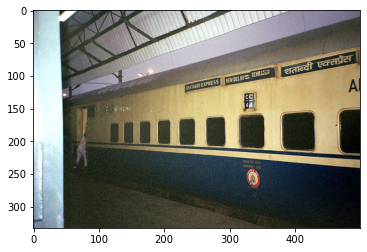

In [25]:
# 3. 이미지 원본 데이터 확인
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
# 4. 전처리 클래스
color_mean = (104, 117 ,123) # (bgr) 색상의 평균값->디폴트값임 특정 작업에 따라 달라질 수 있으나 대부분 해당값을 사용함
input_size = 300 #SSD는 300x300 이미지 사이즈 사용
transform = DataTransform(input_size, color_mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


boxes1 [[ 52.  86. 470. 419.]
 [157.  43. 288. 166.]]


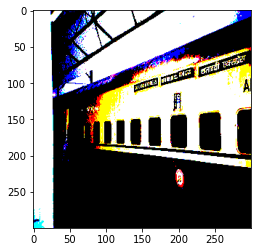

In [27]:
# 5. Train image
phase = 'train' #train버전 변환 
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4]) #trainsform(이미지, 버전, 박스좌표.라벨링값)
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
img_transformed.shape

(300, 300, 3)

In [29]:
img_transformed

array([[[  45.274994  ,   25.941666  ,    0.94166565],
        [  55.164993  ,   30.164993  ,    6.1649933 ],
        [  62.128326  ,   35.128326  ,   11.128326  ],
        ...,
        [  12.849998  ,  -18.076668  ,  -22.908333  ],
        [  22.055     ,  -14.724998  ,  -13.220001  ],
        [  27.816666  ,  -11.8533325 ,   -9.403336  ]],

       [[  50.880005  ,   31.436676  ,    6.436676  ],
        [  58.33      ,   33.660004  ,    9.660004  ],
        [  64.49832   ,   37.828323  ,   13.828323  ],
        ...,
        [  15.834999  ,  -13.501663  ,  -21.443336  ],
        [  21.515     ,  -10.824997  ,  -18.650002  ],
        [  22.796669  ,  -10.378334  ,  -18.203339  ]],

       [[  56.066666  ,   35.791656  ,   10.883331  ],
        [  60.550003  ,   37.550003  ,   13.550003  ],
        [  65.149994  ,   40.699997  ,   16.699997  ],
        ...,
        [  15.64167   ,  -11.841667  ,  -20.991669  ],
        [  14.824997  ,  -13.074997  ,  -24.525002  ],
        [  14.708336  

In [30]:
boxes

array([[0.104     , 0.25825826, 0.94      , 1.25825826],
       [0.314     , 0.12912913, 0.576     , 0.4984985 ]])

In [31]:
labels

array([12., 14.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


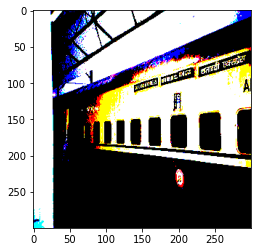

In [32]:
# 6. Val 이미지
phase = 'val'
img_transformed, boxes, labels = transform( img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
img_transformed

array([[[  45.274994  ,   25.941666  ,    0.94166565],
        [  55.164993  ,   30.164993  ,    6.1649933 ],
        [  62.128326  ,   35.128326  ,   11.128326  ],
        ...,
        [  12.849998  ,  -18.076668  ,  -22.908333  ],
        [  22.055     ,  -14.724998  ,  -13.220001  ],
        [  27.816666  ,  -11.8533325 ,   -9.403336  ]],

       [[  50.880005  ,   31.436676  ,    6.436676  ],
        [  58.33      ,   33.660004  ,    9.660004  ],
        [  64.49832   ,   37.828323  ,   13.828323  ],
        ...,
        [  15.834999  ,  -13.501663  ,  -21.443336  ],
        [  21.515     ,  -10.824997  ,  -18.650002  ],
        [  22.796669  ,  -10.378334  ,  -18.203339  ]],

       [[  56.066666  ,   35.791656  ,   10.883331  ],
        [  60.550003  ,   37.550003  ,   13.550003  ],
        [  65.149994  ,   40.699997  ,   16.699997  ],
        ...,
        [  15.64167   ,  -11.841667  ,  -20.991669  ],
        [  14.824997  ,  -13.074997  ,  -24.525002  ],
        [  14.708336  

In [34]:
boxes

array([[0.104     , 0.25825826, 0.94      , 1.25825826],
       [0.314     , 0.12912913, 0.576     , 0.4984985 ]])

In [35]:
labels

array([12., 14.])

# VOC dataset

In [36]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [37]:
class VOCDataset(Dataset): # VOC2012의 데이터셋을 작성하는 클래스. 파이토치의 dataset 클래스를 상속
    """
    ----------
    img_list : 리스트
        이미지 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list #이미지 경로
        self.anno_list = anno_list #어노테이션 파일 경로
        self.phase = phase  # train 또는 val 지정
        self.transform = transform  # 이미지 변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self): #전체 이미지 장수 반환
        '''화상의 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index): #각 이미지 인덱스별 데이터 추출
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
        height, width, channels = img.shape  # 이미지 너비, 높이, 채널 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index] #인덱스별로 어노테이션 파일 경로
        anno_list = self.transform_anno(anno_file_path, width, height) #XML파일->List변환

        # 3. 전처리 실시(이미지 리사이즈, 좌표변환)
        img, boxes, labels = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4]) #변환된 이미지, 박스 좌표값, 라벨 인덱스 추출

        # 색상 채널의 순서가 BGR이므로 RGB로 순서 변경
        # (높이, 폭, 색상 채널)의 순서를 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1) #numpy배열을 Tensor로 변환->GPU는 Tensor를 사용함

        # BBox와 라벨을 세트로 한 np.array 작성. 변수 이름 gt는 ground truth의 의미
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1))) #실제 바운딩박스 좌표와 라벨명, 추후 예측에 사용됨

        return img, gt, height, width #변환된 이미지, 실제 박스좌표 라벨값, 실제 높이, 너비

# train img. train annotation 확인

In [38]:
# train image list
train_img_list[:5]

['C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000008.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000015.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000019.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000023.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000028.jpg']

In [39]:
# train annotation list
train_anno_list[:5]

['C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000008.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000015.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000019.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000023.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000028.xml']

# valid img. valid annotation 확인

In [40]:
# valid image list
val_img_list[:5]

['C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000002.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000003.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000007.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000009.jpg',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/JPEGImages\\2008_000016.jpg']

In [41]:
# valid annotation list
val_anno_list[:5]

['C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000002.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000003.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000007.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000009.xml',
 'C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/Annotations\\2008_000016.xml']

# Train, Valid 모두 phase는 Train으로 라벨값과 box값이 나와야함

In [42]:
# 동작 확인
color_mean = (104, 117, 123) # BGR 평균값
input_size = 300 # 이미지 input 사이즈를 300*300으로 (고정)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                transform=DataTransform(input_size, color_mean),
                transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='train',
                transform=DataTransform(input_size, color_mean), 
                transform_anno=Anno_xml2list(voc_classes))

In [43]:
# Train 예시
train_dataset.pull_item(1)[2]

boxes1 [[269.   0. 377. 175.]
 [ 56.   0. 163. 149.]]


327

# 학습을 위한 DataLoader

In [44]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 이미지마다 다르다.
    이미지 내의 물체 수가 두개이면 (2, 5)사이즈이지만[(좌표값, 라벨값), (좌표값, 라벨값)], 세 개이면 (3, 5)으로 바뀜.
    각 이미지 마다 객체 수가 달라서 라벨링 파일의 사이즈가 다를 수 있음
    한 이미지 내에 라벨링된 객체의 개수가 다른 경우에도 데이터로더를 사용할 수 있도록 collate_fn 함수로 처리
    collate_fn은 파이토치 리스트로 mini batch를 작성하는 함수.
    미니 배치 분량 이미지는 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 
    차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.
    """

    targets = [] #box, label값
    imgs = [] #이미지 텐서값
    for sample in batch: #배치당 이미지 샘플 뽑기
        imgs.append(sample[0])  # sample[0]은 이미지 텐서
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt->좌표값과 라벨 인덱스

    # imgs는 미니배치 크기 리스트
    # 리스트 요소는 torch.Size([3, 300, 300])
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환->앞에 배치 차원이 추가됨->이미지 분석에서 모두 동일함
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt 리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n, 5] 
    # n은 화상마다 다르며 화상 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets

In [45]:
# 데이터 로더 작성
batch_size = 4

# Train
train_dataloader = DataLoader(train_dataset, batch_size =batch_size, shuffle=True, collate_fn=od_collate_fn)

# Valid
val_dataloader = DataLoader(val_dataset, batch_size =batch_size, shuffle=True, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {'train' : train_dataloader,'val' : val_dataloader}

In [46]:
img,target=next(iter(train_dataloader))

boxes1 [[  0. 138. 374. 499.]
 [  0.   0. 122. 149.]
 [162. 103. 256. 169.]
 [  0. 129.  91. 271.]]
boxes1 [[202. 126. 311. 230.]
 [325.  47. 414. 143.]
 [358. 161. 393. 276.]]
boxes1 [[144. 113. 433. 279.]]
boxes1 [[  0. 122.  53. 333.]
 [248.  96. 365. 333.]
 [ 84. 115. 291. 333.]
 [127. 115. 183. 211.]
 [375.  96. 435. 248.]
 [445. 146. 499. 275.]
 [429.  94. 499. 279.]
 [  0. 249. 145. 333.]
 [ 89. 224. 368. 333.]
 [193. 257. 492. 333.]]


In [47]:
print(len(img)) #배치 사이즈에 맞게 4개의 이미지 텐서값 적재됨

4


In [48]:
# 이미지 사이즈 확인
for i in img:
    print(i.size())

torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
torch.Size([3, 300, 300])
torch.Size([3, 300, 300])


In [49]:
print(len(target)) #[박스값, 라벨링 인덱스]

4


In [50]:
target

[tensor([[ 0.0000,  0.2760,  0.9973,  0.9980, 10.0000],
         [ 0.0000,  0.0000,  0.3253,  0.2980, 15.0000],
         [ 0.4320,  0.2060,  0.6827,  0.3380,  8.0000],
         [ 0.0000,  0.2580,  0.2427,  0.5420,  8.0000]]),
 tensor([[0.4040, 0.3784, 0.6220, 0.6907, 2.0000],
         [0.6500, 0.1411, 0.8280, 0.4294, 2.0000],
         [0.7160, 0.4835, 0.7860, 0.8288, 2.0000]]),
 tensor([[0.2880, 0.3393, 0.8660, 0.8378, 3.0000]]),
 tensor([[ 0.0000,  0.3653,  0.1060,  0.9970, 14.0000],
         [ 0.4960,  0.2874,  0.7300,  0.9970, 14.0000],
         [ 0.1680,  0.3443,  0.5820,  0.9970, 14.0000],
         [ 0.2540,  0.3443,  0.3660,  0.6317, 14.0000],
         [ 0.7500,  0.2874,  0.8700,  0.7425, 14.0000],
         [ 0.8900,  0.4371,  0.9980,  0.8234, 14.0000],
         [ 0.8580,  0.2814,  0.9980,  0.8353, 14.0000],
         [ 0.0000,  0.7455,  0.2900,  0.9970,  1.0000],
         [ 0.1780,  0.6707,  0.7360,  0.9970,  1.0000],
         [ 0.3860,  0.7695,  0.9840,  0.9970,  1.0000]])]

In [51]:
target[0].size()

torch.Size([4, 5])

# Backbone Build

In [52]:
# 34층에 걸친 vgg 모듈을 작성

def make_vgg():
    layers = [] #빈 리스트 생성
    in_channels = 3  # 색 채널 수

    # vgg 모듈에서 사용하는 합성곱 층이나 최대 풀링 채널 수 
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,256, 'MC', 512, 512, 512, 'M', 512, 512, 512]
    # M-> MAX Pooling, MC->Max Pooling with Channel Decrease 

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 계산 결과(float)에서 출력 크기의 소수점을 올려 정수로 하는 모드
            # default는 계산 결과(float)에서 출력 크기의 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1) #Max Pooling이 아니라면 지정해놓은 Channel이 out channel로 들어감
            # ReLU 인수 inplace는 ReLU에 대한 입력을 메모리 상에 유지할 것인지, 혹은
            # 입력을 재작성 하여 출력으로 바꾼 후 메모리상에 유지하지 않을 것인지를 나타냄.
            # inplace=True 입력 시 메모리상에 입력을 유지하지 않고, 입력을 재작성 (메모리 절약됨)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v #다음 층의 in channel 저장

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

In [53]:
# 동작 확인
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

# VGG34이후 보조 Network 구현

### 8층에 걸친 extras 모듈을 작성

vgg 최종 output은 10x10x1024

In [54]:
def make_extras():
    layers = []
    in_channels = 1024  # vgg모듈에서 출력된 extra에 입력되는 화상 채널 수 

    # extra 모듈의 합성곱 층 채널 수를 설정하는 구성(configuration)
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]

    
# 활성화 함수의 ReLU는 SSD 모듈의 순전파에서 준비하고, 
# extra에서는 준비하지 않음.
    
    return nn.ModuleList(layers)

In [55]:
# 동작 확인
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


# Detection & Classifier

## Layer Define

### loc_layers: 디폴트 박스의 오프셋을 출력하는 층. 디폴트 박스는 4개의 값을 예측해야함->x좌표.

### conf_layers: 디폴트 박스 각 클래스의 신뢰도를 출력하는 층임

In [56]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]): #6번의 Detection & Classifier

    loc_layers = [] # 디폴트 박스의 오프셋을 출력하는 loc_layers와
    conf_layers = [] # 디폴트 박스 각 클래스 신뢰도 confidence를 출력하는 conf_layers 작성

    # VGG의 22층, conv4_3(source1)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0] * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]  * num_classes, kernel_size=3, padding=1)]

    # VGG의 최종층(source2)의 합성곱 층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]   * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1] * num_classes, kernel_size=3, padding=1)]

    # extra(source3)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]  * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]   * num_classes, kernel_size=3, padding=1)]

    # extra（source4)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]  * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]  * num_classes, kernel_size=3, padding=1)]

    # extra（source5）의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]  * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]  * num_classes, kernel_size=3, padding=1)]

    # extra（source6）의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]    * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]  * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

In [57]:
# 동작 확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# L2Norm

## <span style='color:red'>conv4_3에서 출력에 적용하는 L2Norm층을 구현

### <span style='color:red'>L2Norm 이란 SSD(Single Shot MultiBox Detector)에서 L2Norm은 특징 맵의 정규화에 사용됩니다.<br> L2Norm은 입력 특징 맵의 각 채널을 해당 채널의 L2 노름(크기)으로 나누어 정규화하는 역할을 합니다

L2Norm은 주로 SSD의 특징 추출 네트워크인 VGG 등에서 사용됩니다.

특히, SSD에서는 다양한 크기의 특징 맵을 사용하여 다양한 크기의 객체를 탐지할 수 있습니다. 

그러나 이러한 다양한 크기의 특징 맵을 사용하면서도 동일한 스케일의 특징 맵끼리 비교 가능한 범위로 정규화하기 위해 L2Norm을 사용합니다.

즉 각 채널의 탠서값을 정규화하여 분석에 진행하기 위해 L2Norm 층을 구현해야함

# 파라미터 정의

## <span style='color:blue'> self.scale: L2Norm 층의 가중치(weight)의 초기값으로 사용 1~20까지 무작위 선택 가능 계속 튜닝 해야함

## <span style='color:blue'> self.reset_parameters: 모델을 시작할때 가중치를 적절한 값으로 초기화하고 학습을 진행해줌 self.weight값이 self.scale값으로 모두 초기화 됨

## <span style='color:blue'> self.eps: 분모에 추가되는 작은 상수입니다. 이 작은 상수는 분모에 0이 포함되는 경우를 방지하기 위해 사용

## <span style='color:blue'> self.weight: input 피처맵 채널 수 만큼 weight 텐서 저장

In [58]:
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  #  부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels)) #채널수 만큼의 가중치 텐서 저장
        self.scale = scale  # 계수 weight의 초깃값으로 설정할 값
        self.reset_parameters()  # 파라미터 초기화
        self.eps = 1e-6

    def reset_parameters(self):
        '''결합 파라미터의 scale 크기 값으로 초기화를 실행'''
        init.constant_(self.weight, self.scale)  # weight 값이 모두 scale(=20)이 된다.  PyTorch의 초기화 함수. 이 함수는 입력된 텐서의 모든 원소를 지정된 값으로 초기화

    def forward(self, x):
        '''
        38*38의 피처맵에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다.
        38*38개의 값을 사용하여 각 피처맵을 정규화한 후 계수를 곱하여 계산하는 층
        '''

        # 각 채널의 38*38개 특징량의 채널 방향 제곱합을 계산하고
        # 루트를 구해 나누어 정규화한다.
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])
        # norm을 사용하여 피처맵의 각 채널별로 정규화를 수행
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps #, 각 샘플에 대한 피처맵의 제곱합의 제곱근 값, 피처맵의 특징값을 정규화하는 과정에서 사용됩니다.
        x = torch.div(x, norm) #x=피처맵, norm 피처맵의 각 채널에 대한 제곱합의 제곱근 즉 피처맵을 각 채널에 대한 제곱합의 제곱근으로 나누어 정규화된값이 최종 x임

        # 계수를 곱한다. 계수는 채널마다 하나로, 512개의 계수를 갖는다.
        # self.weight의 텐서 사이즈는 torch.Size([512])로,
        # torch.Size([batch_num, 512, 38, 38])까지 변형한다.
        weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) #self.weight=512개의 텐서->unsqueeze를 통해 batch, width, height 값을 x와 같은 값으로 맞춰주고 곱햐줌
        out = weights * x #중치인 weights와 입력값인 x를 원소별로 곱하여 가중치를 적용한 결과인 out, 이는 객체 탐지에서 각 특징 맵에 대해 클래스 신뢰도를 예측하는 과정으로 사용

        return out

# 디폴트 박스 구현

## <span style='color:red'>앞으로 예측할 박스에 대한 숫자와 크기를 미리 지정하는 과정
    
피처맵에서 특징을 뽑고 원본 이미지인 300x300이미지에서 해당 min size를 기준으로 바운딩 박스를 생성해서 작은 객체부터 큰 객체까지 탐지를 6번 진행

In [59]:
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기 설정
        self.image_size = cfg['input_size']  # 이미지 크기는 300
        # [38, 19, …] 각 source의 특징량 맵 크기
        self.feature_maps = cfg['feature_maps'] # 바운딩 박스 예측을 시작하는 피처맵의 채널 수 지정
        self.num_priors = len(cfg["feature_maps"])  # source 개수 = 6->6번의 Detection&classify를 진행함
        self.steps = cfg['steps']  # step의 크기가 클수록 많은 영역을 한번에 보기 때문에 작은 객체까지 탐지가 가능하고, 픽셀이 작을 수록 객체의 세세한 부분을 잡아 큰 객체를 후에 탐지할 수 있음

        self.min_sizes = cfg['min_sizes']
        # [30, 60, …] 작은 정사각형의 DBox 픽셀 크기(정확히는 면적)

        self.max_sizes = cfg['max_sizes']
        # [60, 111, …] 큰 정사각형의 DBox 픽셀 크기(정확히는 면적)

        self.aspect_ratios = cfg['aspect_ratios']  # 정사각형의 DBox 화면비(종횡비), 비율이 다양한 이유는 이미지내의 객체들의 가로세로 비율이 다양하기 때문

    def make_dbox_list(self):
        '''DBox 작성'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            #k=0, f=38, k=1, f=19,,, 인덱스와 피처맵값 zip형태
            # product는 itertools 모듈에 있는 함수로, 주어진 반복 가능한 객체들의 모든 조합을 반환하는 함수. product 함수는 중첩된 for 루프의 대안으로 사용
            for i, j in product(range(f), repeat=2):  # f 까지의 수로 두 쌍의 조합을 작성. f_p_2개,
                
                # 특징량의 화상 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x,y. 0~1 로 정규화되어 있다.->중심값인 0.5를 더해주고 피처맵의 크기로 나눠줌
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                
                ##아래 부분 이해 필요

                # 화면비 1의 작은 DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 오 ㅣ화면비의 defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k*sqrt(ar), s_k*sqrt(ar)]

        # DBox를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 이미지 밖으로 돌출되는 것을 막기 위해 크기를 최소 0, 최대 1로 한다.
        output.clamp_(max=1, min=0)
        return output

# 각 디폴트 박스의 좌표값을 데이터프레임화

In [60]:
# 동작 확인

# DBox 작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# dbox 출력 확인 
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.141421,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,1.000000,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


# SSD 구현

In [61]:
# SSD클래스 작성


class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference
        self.num_classes = cfg["num_classes"]  # 클래스 수

        # SSD 네트워크 작성
        self.vgg = make_vgg() #VGG Network
        self.extras = make_extras() #추가 Network
        self.L2Norm = L2Norm() #L2Norm정규화
        self.loc, self.conf = make_loc_conf(cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론 시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # loc와 conf에 입력 source1 ~ 6 저장
        loc = list()  # loc의 출력 저장
        conf = list()  # conf의 출력 저장

        # vgg의 conv4_3까지 계산
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3의 출력을 L2Norm에 입력하고, source1을 작성하여 sources에 추가
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vgg를 마지막까지 계산하여 source2를 작성하고 sources에 추가
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extras의 conv와 ReLU 계산
        # source3～6을 sources에 추가
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLU를 하여 source에 넣는다.
                sources.append(x)

        # source1 ~ 6 에 각각 대응하는 합성곱을 1회씩 적용
        # zip으로 for 루프의 여러 리스트 요소 취득
        # source1 ~ 6 까지 있어 루프가 6회 실시
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permute로 요소의 순서를 교체
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x), c(x)로 합성곱 실행
            # l(x), c(x)으 ㅣ출력 크기는 [batch_num, 4*화면비의 종류 수 , featuremap높이, featuremap폭]
            # source에 따라 화면비으 ㅣ종류 수가 다르며, 번거로워 순서를 바꾸어서 조정
            # permute로 요소 순서를 당므과 같이 교체 
            # [minibatch 수 , featuremap 수 , featuremap 수 ,4*화면비의 종류 수]
            # torch.contiguous()은 메모리 상에 연속적으로 요소를 배치하는 명령
            # 이후 view 함수 사용
            # view를 수행하므로 대상의 변수가 메모리 상에 연속적으로 배치되어야 한다.

        # loc와 conf의 모양 변형
        # loc의 크기는 torch.Size([batch_num, 34928])
        # conf의 크기는 torch.Size([batch_num, 183372])가 된다.
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # loc와 conf의 모양 조정
        # lloc의 크기는 torch.Size([batch_num, 8732, 4])
        # conf의 크기는 torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 마지막으로 출력
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  #  추론 시
            # detect 클래스의 forward 실행
            # 반환 값의 크기는 torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 학습 시
            return output
            # 반환 값은 (loc, conf, dbox_list)의 튜플

In [62]:
# Decode

In [63]:
# 오프셋 정보로  DBox를 BBox로 변환하는 함수

def decode(loc, dbox_list):
    """
    오프셋 정보로  DBox를 BBox로 변환한다.
    Parameters
    ----------
    loc:  [8732,4]
        SSD 모델로 추론하는 오프셋 정보
    dbox_list: [8732,4]
        DBox 정보
    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox 정보
    """

    # DBox는 [cx, cy, width, height]로 저장되었다.
    # loc도 [Δcx, Δcy, Δwidth, Δheight]로 저장되었다.

    # 오프셋 정보로 BBox를 구한다.
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxes의 크기는 torch.Size([8732, 4])가 된다.

    # BBox의 좌표 정보를 [cx, cy, width, height]에서 [xmin, ymin, xmax, ymax] 로 변경
    boxes[:, :2] -= boxes[:, 2:] / 2  # 좌표 (xmin,ymin)로 변환
    boxes[:, 2:] += boxes[:, :2]  # 좌표 (xmax,ymax)로 변환

# Non-maximum Suppression 실시 함수 구현

미리 8,732개의 DBox를 준비하여 물체를 감지하므로, BBox를 계산하면 화상 속 동일한 물체에 다른 BBox가 조금 다르게 복수 피팅 될 때가 있다. 

겹치는 BBox를 삭제하고 하나의 물체에 하나의 BBox만 남기는 처리를 Non-Maximum Suppression 이라고 한다.

In [64]:
# Non-Maximum Suppression을 실시하는 함수


def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression을 실시하는 함수
    boxes중 겹치는（overlap이상) BBox 삭제
    Parameters
    ----------
    boxes : [신뢰도 임곗값（0.01)을 넘은 BBox 수,4]
        BBox 정보
    scores :[신뢰도 임곗값（0.01)을 넘은 BBox 수]
        conf 정보
    Returns
    -------
    keep : 리스트
        conf의 내림차순으로 nms를 통과한 index를 저장
    count：int
        nms를 통과한 BBox 수
    """

    # return 모형 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([신뢰도 임곗값을 넘은 BBox 수)], 요소는 전부 0

    # 각 BBox의 면적 area 계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes 복사. 나중에 BBox 중복도(IOU) 계산 시 모형으로 준비
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # scores를 오름차순으로 나열
    v, idx = scores.sort(0)

    # 상위 top_k개(200개)의 BBox index를 꺼낸다(200개가 존재하지 않는 경우도 있음)
    idx = idx[-top_k:]

    # idx의 요소 수가 0이 아닌 한 루프한다.
    while idx.numel() > 0:
        i = idx[-1]  # conf의 최대 index를 i로 지정

        # keep의 끝에 conf 최대 index 저장
        # 이 index의 BBox와 크게 겹치는 BBox를 삭제
        keep[count] = i
        count += 1

        # 마지막 BBox는 루프를 빠져나옴
        if idx.size(0) == 1:
            break

        # 현재 conf 최대의 index를 keep에 저장했으므로 idx를 하나 감소시킴
        idx = idx[:-1]

        # -------------------
        # 지금부터 keep에 저장한 BBox와 크게 겹치는 BBox를 추출하여 삭제
        # -------------------
        # 하나 감소시킨 idx까지의 BBox를 out으로 지정한 변수로 작성
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # 모든 BBox를 현재 BBox=index가 i로 겹치는 값까지로 설정(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # w와 h의 텐서 크기를 index 하나 줄인 것으로 한다.
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clamp한 상태에서 BBox의 폭과 높이를 구한다.
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 폭이나 높이가 음수인 것은 0으로 한다.
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clamp된 상태 면적을 구한다.
        inter = tmp_w*tmp_h

        # IoU = intersect 부분 / (area(a) + area(b) - intersect 부분) 계산
        rem_areas = torch.index_select(area, 0, idx)  # 각 BBox의 원래 면적
        union = (rem_areas - inter) + area[i]  # 두 구역의 합(OR) 면적
        IoU = inter/union

        # IoU가 overlap보다 작은 idx만 남긴다
        idx = idx[IoU.le(overlap)]  # le은 Less than or Equal to 처리를 하는 연산
        # IoU가 overlap보다 큰 idx는 처음 선택한 keep에 저장한 idx와 동일한 물체에 BBox를 둘러싸고 있어 삭제
    
    # while 루프에서 빠져나오면 종료

    return keep, count

# Detect

In [65]:
class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  
        # conf를 소프트맥스 함수로 정규화하기 위해 준비
        self.conf_thresh = conf_thresh  
        # conf가 conf_thresh=0.01보다 높은 DBox만 취급
        self.top_k = top_k  
        # conf가 높은 top_k개를 nm_supression으로 계산에 사용하는 top_k = 200
        self.nms_thresh = nms_thresh  
        # nm_supression으로 IOU가 nms_thresh=0.45보다 크면 동일한 물체의 BBox로 간주

    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계산 실행
        
        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num, 8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox 정보
        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num, 클래스, conf의 top200, BBox 정보）
        """

        # 각 크기 취득
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox의 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # conf는 소프트맥스를 적용하여 정규화
        conf_data = self.softmax(conf_data)

        # 출력 형식을 작성. 텐서 크기 [minibatch 수, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data 순서를 [batch_num,8732,num_classes]에서 [batch_num, num_classes,8732]로 변경
        conf_preds = conf_data.transpose(2, 1)

        # 미니 배치마다 루프
        for i in range(num_batch):

            # 1. loc와 DBox로 수정한 BBox [xmin, ymin, xmax, ymax] 를 구한다
            decoded_boxes = decode(loc_data[i], dbox_list)

            # conf의 복사본 작성
            conf_scores = conf_preds[i].clone()

            # 화상 클래스별 루프(배경 클래스의 index인 0은 계산하지 않고 index=1부터）
            for cl in range(1, num_classes):

                # 2.conf의 임곗값을 넘은 BBox를 꺼낸다.
                # conf의 임곗값을 넘고 있는지 마스크를 작성하여
                # 임곗값을 넘은 conf의 인덱스를 c_mask로 취득
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gt는 Greater than을 의미. gt로 임곗값이 넘으면 1, 이하는 0
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scores는 torch.Size([임곗값을 넘은 BBox 수])
                scores = conf_scores[cl][c_mask]

                # 임곗값을 넘은 conf가 없는 경우, scores=[]는 아무것도 하지 않음.
                if scores.nelement() == 0:  # nelement로 요소 수의 합계를 구함
                    continue

                # c_mask를 decoded_boxes에 적용할 수 있도록 크기 변경
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_mask를 decoded_boxes로 적용
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]로 1차원이 되기 때문에
                # view에서 (임곗값을 넘은 BBox 수, 4) 크기로 바꿈

                # 3. Non-Maximum Suppression을 실시하여 중복되는 BBox 제거
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：conf의 내림차순으로 Non-Maximum Suppression을 통과한 index 작성
                # count：Non-Maximum Suppression를 통과한 BBox 수

                # output에 Non-Maximum Suppression를 뺀 결과 저장
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

# MultiBoxLoss

In [66]:
class MultiBoxLoss(nn.Module):
    """SSD의 손실함수 클래스 """

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 match 함수의 jaccard 계수의 임계치
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Mining의 음과 양 비율
        self.device = device  # 계산 device(CPU | GPU)

    def forward(self, predictions, targets):
        """
        손실함수 계산
        Parameters
        ----------
        predictions : SSD net의 훈련 시 출력 (tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 
            8732, 21]), dbox_list=torch.Size [8732,4])。
        targets : [num_batch, num_objs, 5]
            5는 정답인 어노테이션 정보[xmin, ymin, xmax, ymax, label_ind]
        Returns
        -------
        loss_l : 텐서
            loc의 손실 값
        loss_c : 텐서
            conf의 손실 값
        """

        # SSD의 출력이 튜플로 되어 있어 개별적으로 분리함
        loc_data, conf_data, dbox_list = predictions

        # 요소 수를 파악
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox의 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수= 21

        # 손실 계산에 사용할 것을 저장하는 변수 작성
        # conf_t_label：각 DBox에 가장 가까운 정답 BBox의 라벨을 저장 
        # loc_t: 각 DBox에 가장 가까운 정답 BBox의 위치 정보 저장 
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_t와 conf_t_label에 
        # DBox와 정답 어노테이션 targets를 amtch한 결과 덮어쓰기
        for idx in range(num_batch):  # 미니 배치 루프

            # 현재 미니 배치의 정답 어노테이션 BBox와 라벨 취득
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # 라벨 [물체1 라벨, 물체2 라벨, ...]
            labels = targets[idx][:, -1].to(self.device)

            # 디폴트 박스를 새로운 변수로 준비
            dbox = dbox_list.to(self.device)

            # match 함수를 실행하여 loc_t와 conf_t_label 내용 갱신
            # loc_t: 각 DBox에 가장 가까운 정답 BBox 위치 정보가 덮어써짐.
            # conf_t_label：각 DBox에 가장 가까운 정답 BBox 라벨이 덮어써짐.
            # 단, 가장 가까운 BBox와 jaccard overlap이 0.5보다 작은 경우,
            # 정답 BBox의 라벨 conf_t_label은 배경 클래스 0으로 한다.
            variance = [0.1, 0.2]
            # 이 variance는 DBox에서 BBox로 보정 계산할 때 사용하는 식의 계수
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 위치 손실 : loss_l을 계산
        # Smooth L1 함수로 손실 계산. 단, 물체를 발견한 DBox의 오프셋만 계산
        # ----------
        # 물체를 감지한 BBox를 꺼내는 마스크 작성
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_mask를 loc_data 크기로 변형
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBox의 loc_data와 지도 데이터 loc_t 취득
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 물체를 발견한 Positive DBox의 오프셋 정보 loc_t의 손실(오차)를 계산
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # 클래스 예측의 손실 : loss_c를 계산
        # 교차 엔트로피 오차 함수로 손실 계산. 단 배경 클래스가 정답인 DBox가 압도적으로 많으므로,
        # Hard Negative Mining을 실시하여 물체 발견 DBox 및 배경 클래스 DBox의 비율이 1:3이 되도록 한다.
        # 배경 클래스 DBox로 예상한 것 중 손실이 적은 것은 클래스 예측 손실에서 제외
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # 클래스 예측의 손실함수 계산(reduction='none'으로 하여 합을 취하지 않고 차원 보존)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # Negative DBox중 Hard Negative Mining으로 
        # 추출하는 것을 구하는 마스크 작성
        # -----------------

        # 물체를 발견한 Positive DBox의 손실을 0으로 한다.
        # (주의) 물체는 label이 1 이상, 라벨 0은 배경을 의미
        num_pos = pos_mask.long().sum(1, keepdim=True)  # 미니 배치별 물체 클래스 예측 수
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 물체를 발견한 DBox는 손실 0으로 한다.

        # Hard Negative Mining
        # 각 DBox 손실의 크기 loss_c 순위 idx_rank를 구함
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        #  (주의) 구현된 코드는 특수하며 직관적이지 않음.
        # 위 두 줄의 요점은 각 DBox에 대해 손실 크기가 몇 번째인지의 정보를 
        # idx_rank 변수로 빠르게 얻는 코드이다.
        
        # DBox의 손실 값이 큰 쪽부터 내림차순으로 정렬하여, 
        # DBox의 내림차순의 index를 loss_idx에 저장한다.
        # 손실 크기 loss_c의 순위 idx_rank를 구한다.
        # 내림차순이 된 배열 index인 loss_idx를 0부터 8732까지 오름차순으로 다시 정렬하기 위하여
        # 몇 번째 loss_idx의 인덱스를 취할 지 나타내는 것이 idx_rank이다.
        # 예를 들면 idx_rank 요소의 0번째 = idx_rank[0]을 구하는 것은 loss_idx의 값이 0인 요소,
        # 즉 loss_idx[?] =0은 원래 loss_c의 요소 0번째는 내림차순으로 정렬된 loss_idx의 
        # 몇 번째입니까? 를구하는 것이 되어 결과적으로, 
        # ? = idx_rank[0]은 loss_c의 요소 0번째가 내림차순으로 몇 번째인지 나타냄

        # 배경 DBox의 수 num_neg를 구한다. HardNegative Mining으로 
        # 물체 발견 DBox으 ㅣ수 num_pos의 세 배 (self.negpos_ratio 배)로 한다.
        # DBox의 수를 초과한 경우에는 DBox의 수를 상한으로 한다.
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rank에 각 DBox의 손실 크기가 위에서부터 몇 번째인지 저장되었다.
        # 배경 DBox의 수 num_neg보다 순위가 낮은(손실이 큰) DBox를 취하는 마스크 작성
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # (종료) 지금부터 Negative DBox 중 Hard Negative Mining으로 추출할 것을 구하는 마스크를 작성
        # -----------------

        # 마스크 모양을 고쳐 conf_data에 맞춘다
        # pos_idx_mask는 Positive DBox의 conf를 꺼내는 마스크이다.
        # neg_idx_mask는 Hard Negative Mining으로 추출한 Negative DBox의 conf를 꺼내는 마스크이다.
        # pos_mask：torch.Size([num_batch, 8732])
        # --> pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_data에서 pos와 neg만 꺼내서 conf_hnm으로 한다. 
        # 형태는 torch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # gt는 greater than (>)의 약칭. mask가 1인 index를 꺼낸다
        # pos_idx_mask+neg_idx_mask는 덧셈이지만 index로 mask를 정리할 뿐임.
        # pos이든 neg이든 마스크가 1인 것을 더해 하나의 리스트로 만들어 이를 gt로 췯그한다.

        # 마찬가지로 지도 데이터인 conf_t_label에서 pos와 neg만 꺼내, conf_t_label_hnm 으로 
        # torch.Size([pos+neg]) 형태가 된다
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidence의 손실함수 계산(요소의 합계=sum을 구함)
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 물체를 발견한 BBox의 수 N (전체 미니 배치의 합계) 으로 손실을 나눈다.
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

In [72]:
root_path='C:/Users/user/Desktop/SSD/data/VOCdevkit/VOC2012/'

In [74]:
train_img_list, train_anno_list, val_img_list, val_anno_list=make_datapath_list(rootpath=root_path)

# 데이터셋 구현

In [76]:
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath=root_path)

# Dataset 작성
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep','sofa','train','tvmonitor']

color_mean = (104, 117, 123) # BGR 색 평균 값 

input_size = 300 # input 크기를 300*300 으로 설정

train_dataset = VOCDataset(train_img_list, train_anno_list, 
phase='train', transform=DataTransform(
                            input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val',
						transform=DataTransform(input_size, color_mean), 
                            transform_anno=Anno_xml2list(voc_classes))

# dataloader 작성
batch_size=32

train_dataloader = data.DataLoader(
                            train_dataset, batch_size=batch_size, 
                            shuffle=True, 
                       	collate_fn = od_collate_fn)

val_dataloader = data.DataLoader(
                            val_dataset, batch_size = batch_size,
                            shuffle=False, collate_fn= od_collate_fn)

# 사전 오브젝트로 정리
dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}

In [79]:
# SSD300 설정
ssd_cfg = {
    'num_classes' : 21,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4],  # 출력할 DBox의 화면 비 종류
    'feature_maps' : [38, 19, 10, 5, 3, 1],  # 각 source 화상 크기
    'steps' : [8, 16, 32, 64, 100, 300],
    'min_sizes' : [30, 60, 111, 162, 213, 264] , # DBox 크기(최소)
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox 크기(최대)
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]]
}

# SSD 네트워크 모델
net = SSD(phase='train', cfg=ssd_cfg)

# SSD 초기 가중치 설정
# ssd의 vgg에 가중치 로드
vgg_weights = torch.load('./weights_model/vgg16_reducedfc.pth') # 다운 받아야함
net.vgg.load_state_dict(vgg_weights)

# ssd의 기타 네트워크 가중치는 He의 초기치로 초기화

def weights_init(m) :
    if isinstance(m, nn.Conv2d) :
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None : # bias 항이 있는 경우
            nn.init.constant_(m.bias, 0.0)
            
# He의 초기치 적용
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPU를 사용할 수 있는지 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 장치 : {device}')

print('네트워크 설정 완료 : 학습된 가중치를 로드했습니다.')

사용 중인 장치 : cuda:0
네트워크 설정 완료 : 학습된 가중치를 로드했습니다.


# 손실함수 구현 및 학습

In [89]:
# 손실함수 설정
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 최적화 기법 선정
optimizer = optim.SGD(net.parameters(), lr=1e-3, 
                             momentum = 0.9, weight_decay=5e-4)

# 학습 및 검증 실시
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs) :
    
    # GPU 사용 확인
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'사용 중인 장치 : {device}')
    
    # 네트워크를 gpu로
    net.to(device)
    
    # 네트워크가 어느정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 반복자 카운터 설정
    iteration = 1
    epoch_train_loss = 0.0 # 에포크 손실 합
    epoch_val_loss = 0.0 # 에포크 손실 합
    logs = []
    
    
    # 에폭 루프
    for epoch in range(num_epochs+1) :
        
        # 시작 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        print('-' * 20)
        print(f'Epoch : {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        # 에폭 별 훈련 및 검증 루프
        for phase in ['train', 'val'] :
            if phase == 'train' :
                net.train() # 모델을 훈련 모드로
                print('(train)')
            else :
                if ((epoch+1) % 10  == 0 ) :
                    net.eval() # 모델을 검증 모드로
                    print('-' * 20)
                    print('(val)')
                else :
                    # 검증은 10 회 중 1회만 실시
                    continue
                    
            # 데이터 로더에서 미니 배치씩 꺼내 루프
            for images, targets in dataloaders_dict[phase] :
                # GPU를 사용할 수 있으면 GPU에 데이터를 보낸다.
                images = images.to(device)
                # 리스트 각 요소의 텐서를 GPUㄹ
                targets = [ann.to(device) for ann in targets]
                # 옵티마이저 초기화
                optimizer.zero_grad()
                
                
                # 순전파 계산
                with torch.set_grad_enabled(phase=='train') :
                    # 순전파 계산
                    outputs = net(images)
                    loss_l, loss_c = criterion(outputs, targets) 
                    loss = loss_l + loss_c
                    
                    # 훈련 시에는 역전파
                    if phase == 'train' :
                        loss.backward() 
                        
                        # 경사가 너무 커지면 계산이 부정확해 clip에서 최대경사 2.0에 고정
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        
                        optimizer.step() # 파라미터 갱신
                        
                        if (iteration % 10 == 0) : # 10 iter에 한 번 손실 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f'반복 {iteration}  || Loss : {loss.item():.4f} || 10 iter : {duration:.4f} \sec.')

                            t_iter_start =time.time()
                            
                        epoch_train_loss += loss.item()
                        iteration += 1
                        
                    # 검증 시
                    else :
                        epoch_val_loss += loss.item()
                        
            
            # epoch의 phase당 손실과 정답률
            t_epoch_finish = time.time()
            print('-' * 20)
            print(f'epoch {epoch+1} || Epoch_Train_loss : {epoch_train_loss:.4f} || Epoch_val_loss : {epoch_val_loss:.4f}')
            
            print(f'timer : {t_epoch_finish - t_epoch_start:.4f} sec')
            
            # 로그 저장
            loc_epoch = {'epoch' : epoch + 1,
                        'train_loss' : epcoh_train_loss,
                        'val_loss' : epoch_val_loss}
            los.append(los_epoch)
            df = pd.DataFrame(logs)
            df.to_csv('log_output.csv')
            
            epoch_train_loss = 0.0 # 에폭 손실 합
            epoch_val_loss = 0.0 # 에폭 손실 합
            
            # 네트워크 저장
            if ((epoch + 1) % 10 == 0 ) :
                torch.save(net.state_dict(), './weights/ssd300_' + str(epoch+1) + '.pth')

                
# 학습 및 검증 실시
num_epochs = 50
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

사용 중인 장치 : cuda:0
--------------------
Epoch : 1/50
--------------------
(train)
boxes1 [[  0.   0. 499. 374.]]
boxes1 [[ 15.  91. 480. 368.]
 [312. 288. 499. 374.]]
boxes1 [[137. 273. 254. 499.]
 [ 11. 246. 130. 499.]
 [143. 296. 269. 494.]]
boxes1 [[109. 130. 493. 283.]]
boxes1 [[ 11.   7. 396. 374.]]
boxes1 [[  0. 168. 335. 460.]
 [142. 210. 262. 278.]
 [165. 212. 223. 269.]]
boxes1 [[ 10. 173.  66. 208.]]
boxes1 [[ 30. 106. 473. 257.]]
boxes1 [[  0.   0. 488. 489.]]
boxes1 [[192. 411. 304. 469.]
 [285. 408. 374. 484.]
 [  0. 339.  34. 365.]]
boxes1 [[156. 113. 439. 302.]]
boxes1 [[ 28.  61. 253. 275.]
 [253.  52. 470. 263.]]
boxes1 [[ 72.   5. 499. 374.]]
boxes1 [[  0.   0. 499. 319.]
 [ 29.   0. 499. 169.]]
boxes1 [[101.   0. 499. 374.]]
boxes1 [[170. 121. 418. 360.]
 [202.   0. 455. 134.]]
boxes1 [[312. 151. 389. 183.]]
boxes1 [[  0. 152. 314. 374.]]
boxes1 [[328.  84. 495. 207.]
 [157. 167. 376. 263.]
 [274. 142. 321. 258.]
 [324. 149. 351. 261.]
 [166. 139. 184. 187.]
 [217. 14

RuntimeError: CUDA out of memory. Tried to allocate 176.00 MiB (GPU 0; 4.00 GiB total capacity; 3.31 GiB already allocated; 0 bytes free; 3.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# 추론

In [ ]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep','sofa','train','tvmonitor']

# SSD 300 설정

ssd_cfg = {
    'num_classes' : 21,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4], # 출력할 DBox 화면비 종류
    'feature_maps' : [38, 19, 10, 5, 3, 1], # 각 source의 화상 크기
    'steps' : [8, 16, 32, 64, 100, 300], # DBox 크기 결정
    'min_sizes' : [30, 60, 111, 162, 213, 264], # DBox 크기 결정
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox 크기 결정
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase='inference', cfg=ssd_cfg)

# SSD의 학습된 가중치 설정
# net_weights = torch.load('./pytorch_advanced/objectdetection/weights/ssd300_50.pth',
#                         map_location={'cuda:0' : 'cpu'})

net_weights = torch.load('./pytorch_advanced/objectdetection/weights/ssd300_mAP_77.43_v2.pth',
                        map_location={'cuda:0' : 'cpu'})

net.load_state_dict(net_weights)

print('네트워크 설정 완료 : 학습 가중치를 로드했습니다.')

# 이미지 읽기

In [ ]:
# 1. 화상 읽기

image_file_path = './pytorch_advanced/objectdetection/data/cowboy-757575_640.jpg'
img = cv2.imread(image_file_path) # [높이][폭][색BGR]
height, width, channels = img.shape # 이미지 크기 취득

# 2. 원본 화상 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 전처리 클래스 작성
color_mean = (104, 117, 123) # BGR 색 평균값
input_size= 300 # 화상 크기를 300*300 으로 설정
transform = DataTransform(input_size, color_mean)

# 4. 전처리
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, '', '' ) # 어노테이션은 없어 ""으로 설정
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD로 예측
net.eval() # 네트워크를 추론 모드로

x = img.unsqueeze(0) # 미니 배치화 : torch.Size([1, 3, 300, 300])

detections = net(x)

print(detections.shape)
print(detections)

# SSD에서의 예측과 이미지 표시

In [ ]:
# pytorch_advanced/2_objectdetection/utils/ssd_predict_show.py
class SSDPredictShow(): 
    """SSD에서의 예측과 이미지 표시를 한꺼번에 하는 클래스"""

    def __init__(self, eval_categories, net):
        self.eval_categories = eval_categories  # 클래스명
        self.net = net  # SSD 네트워크

        color_mean = (104, 117, 123)  # (BGR)색상의 평균치
        input_size = 300  # 사진의 input 크기를 300 × 300으로 한다.
        self.transform = DataTransform(input_size, color_mean)  # 전처리 클래스

    def show(self, image_file_path, data_confidence_level):
        """
        물체 검출의 예측 결과를 표시하는 함수.
        Parameters
        ----------
        image_file_path:  str
            이미지 파일 경로
        data_confidence_level: float
            예측으로 발견할 수 있는 확신도의 역치
        Returns
        -------
        없음. rgb_img에 물체검출결과가 더해진 화상이 나타난다.
        """
        rgb_img, predict_bbox, pre_dict_label_index, scores = self.ssd_predict(
            image_file_path, data_confidence_level)

        self.vis_bbox(rgb_img, bbox=predict_bbox, label_index=pre_dict_label_index,
                      scores=scores, label_names=self.eval_categories)

    def ssd_predict(self, image_file_path, data_confidence_level=0.5):
        """
        SSD에서 예측시키는 함수.
        Parameters
        ----------
        image_file_path:  strt
            이미지 파일 경로
        dataconfidence_level: float
            예측으로 발견할 수 있는 확신도의 역치
        Returns
        -------
        rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores
        """

        # rgb 이미지 데이터 가져오기
        img = cv2.imread(image_file_path)  # [높이] [폭] [색상BGR]
        height, width, channels = img.shape  # 이미지 크기 가져오기
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 화상 전처리
        phase = "val"
        img_transformed, boxes, labels = self.transform(
            img, phase, "", "")  # 어노테이션이 존재하지 않기 때문에 ""로 한다
        img = torch.from_numpy(
            img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # SSD로 예측
        self.net.eval()  # 네트워크를 추론 모드로
        x = img.unsqueeze(0)  # 미니 배치 화：torch.Size([1, 3, 300, 300])

        detections = self.net(x)
        # detections의 형태는 torch.Size (1, 21, 200, 5]) ※200은 top_k 의 값

        # confidence_level 이 기준 이상을 꺼냄
        predict_bbox = []
        pre_dict_label_index = []
        scores = []
        detections = detections.cpu().detach().numpy()

        # 조건 이상의 값을 추출
        find_index = np.where(detections[:, 0:, :, 0] >= data_confidence_level)
        detections = detections[find_index]
        for i in range(len(find_index[1])):  # 추출한 물체 수만큼 루프
            if (find_index[1][i]) > 0:  # 배경 클래스가 아닌 것
                sc = detections[i][0]  # 확신도
                bbox = detections[i][1:] * [width, height, width, height]
                # find_index는 미니뱃지 수, 클래스, top의 tuple
                lable_ind = find_index[1][i]-1
                ## (주석)
                # 배경반이 0이므로 1을 뺀다

                # 반환 값 리스트에 추가
                predict_bbox.append(bbox)
                pre_dict_label_index.append(lable_ind)
                scores.append(sc)

        return rgb_img, predict_bbox, pre_dict_label_index, scores

    def vis_bbox(self, rgb_img, bbox, label_index, scores, label_names):
        """
        물체 검출의 예측 결과를 화상으로 표시시키는 함수.
        Parameters
        ----------
        rgb_img: rgb이미지
        대상 이미지 데이터
        bbox : list
        물체의 비폭스 목록
        label _ index : list
        물체의 라벨에 대한 인덱스
        scores : list
        물체의 확신도
        label _ names : list
        라벨명의 배열
        Returns
        -------
        없음. rgb_img에 물체검출결과가 더해진 화상이 나타난다.
        """
        # 테두리의 색 설정
        num_classes = len(label_names)  # 클래스 수 (배경 제외)
        colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()

        # 이미지 표시
        plt.figure(figsize=(10, 10))
        plt.imshow(rgb_img)
        currentAxis = plt.gca()

        # BBox의 루프
        for i, bb in enumerate(bbox):

            # 라벨 명
            label_name = label_names[label_index[i]]
            color = colors[label_index[i]]  # クラスごとに別の色の枠を与える

            # 테두리에 붙이는 라벨 // 예) person : 0.72
            if scores is not None:
                sc = scores[i]
                display_txt = '%s: %.2f' % (label_name, sc)
            else:
                display_txt = '%s: ans' % (label_name)

            # 테두리 좌표
            xy = (bb[0], bb[1])
            width = bb[2] - bb[0]
            height = bb[3] - bb[1]

            # 직사각형을 그림
            currentAxis.add_patch(plt.Rectangle(
                xy, width, height, fill=False, edgecolor=color, linewidth=2))

            # 직사각형 틀의 왼쪽 상단에 라벨을 그림
            currentAxis.text(xy[0], xy[1], display_txt, bbox={
                             'facecolor': color, 'alpha': 0.5})

In [ ]:
# 화상 예측

img_file_path = '예측할 이미지 경로'

# 예측 및 결과를 화상으로 그린다
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(img_file_path, data_confidence_level=0.6)